<a href="https://colab.research.google.com/github/nqa112/times-series-forecasting/blob/main/dlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BASIC SETUP

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [ ]:
# Set random seed
SEED = 12
torch.manual_seed(SEED)
np.random.seed(SEED)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}.")

Using cpu.


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.figsize'] = 13, 4

# Box
rcParams['axes.spines.top'] = False
rcParams['axes.spines.left'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['navy','goldenrod'])

# Grid and axis thickness, color
rcParams['axes.linewidth'] = 1
rcParams['axes.edgecolor'] = '#5B5859'
rcParams['axes.ymargin'] = 0
rcParams['axes.grid'] = True
rcParams['axes.grid.axis'] = 'y'
rcParams['axes.axisbelow'] = True
rcParams['grid.color'] = 'grey'
rcParams['grid.linewidth'] = 0.5

# xticks, yticks
rcParams['ytick.major.width'] = 0
rcParams['ytick.major.size'] = 0
rcParams['ytick.color'] = '#393433'
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.size'] = 3
rcParams['xtick.color'] = '#393433'

# Line thickness
rcParams['lines.linewidth'] = 1.5

# Saving quality
rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 500
rcParams['savefig.transparent'] = True

## LOAD DATA

In [ ]:
csv_path = Path("BVData.csv")
df = pd.read_csv(csv_path)

# Convert into a DateTime type
df["DateTime"] = pd.to_datetime(df["DateTime"], format="%Y-%m-%d %H:%M")
df = df.drop(columns=["Date", "Time"])

In [ ]:
df.head()

,DateTime,Month,1,2,3,4,5,6,7,8,...,13,14,15,16,17,18,19,20,21,QV
0,2020-01-01 00:00:00,1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
1,2020-01-01 01:00:00,1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
2,2020-01-01 02:00:00,1,0.6,0.0,0.0,0.0,0.2,0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
3,2020-01-01 03:00:00,1,0.6,0.0,0.0,0.0,0.6,0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0
4,2020-01-01 04:00:00,1,0.4,0.0,0.0,0.0,0.8,0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21888 entries, 0 to 21887
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  21888 non-null  datetime64[ns]
 1   Month     21888 non-null  int64         
 2   1         21888 non-null  float64       
 3   2         21888 non-null  float64       
 4   3         21888 non-null  float64       
 5   4         21888 non-null  float64       
 6   5         21888 non-null  float64       
 7   6         21888 non-null  float64       
 8   7         21888 non-null  float64       
 9   8         21888 non-null  float64       
 10  9         21888 non-null  float64       
 11  10        21888 non-null  float64       
 12  11        21888 non-null  float64       
 13  12        21888 non-null  float64       
 14  13        21888 non-null  float64       
 15  14        21888 non-null  float64       
 16  15        21888 non-null  float64       
 17  16        21

## DATA PREPROCESSING

### Feature engineering

#### Date related features

In [ ]:
# Day in a month
df["Day_of_month"] = df.DateTime.apply(lambda x: x.day)
# Day in a week
df["Day_of_week"] = df.DateTime.apply(lambda x: x.dayofweek)
# 24-hour based
df["Hour"] = df.DateTime.apply(lambda x: x.hour)
# Week in a year
df["Week"] = df.DateTime.apply(lambda x: x.week)

# Set "DateTime" column as row index
df = df.set_index("DateTime")
df.head()

,Month,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,QV,Day_of_month,Day_of_week,Hour,Week
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,31.0,1,2,0,1
2020-01-01 01:00:00,1,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,31.0,1,2,1,1
2020-01-01 02:00:00,1,0.6,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,31.0,1,2,2,1
2020-01-01 03:00:00,1,0.6,0.0,0.0,0.0,0.6,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,31.0,1,2,3,1
2020-01-01 04:00:00,1,0.4,0.0,0.0,0.0,0.8,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,31.0,1,2,4,1


In [ ]:
# Move target to the last column
target_feature = "QV"
df.insert(len(df.columns)-1, target_feature, df.pop(target_feature))

### Hyperparameters

In [ ]:
batch_size = 32
in_seq_len = 24
out_seq_len = 12

input_size = df.shape[1]

num_epochs = 100
learning_rate = 5e-3
es_patience = 15
lr_patience = 5

model_save_path = "checkpoint_dlinear.pth"

## DATASET PIPELINE

### Train - Val - Test split

In [ ]:
data = df.values
data.shape

(21888, 27)

In [ ]:
train_ratio, val_ratio = 0.7, 0.2
train_size = int(len(df) * train_ratio)
val_size = int(len(df) * val_ratio)

data_train = data[: train_size]
data_val = data[train_size : train_size+val_size]
data_test = data[train_size+val_size :]

### Feature scaling
Use natural log transformation (with one plus element-wise since log does not accept zero)

In [ ]:
train_scaled = np.log1p(data_train)
val_scaled = np.log1p(data_val)
test_scaled = np.log1p(data_test)

### Create data sequences

In [ ]:
# split a multivariate sequence past, future samples (X and y)
def sequence_generator(arr, past_step=in_seq_len, future_step=out_seq_len):
    # instantiate X and y
    X, y = list(), list()
    for i in range(len(arr)):
        # find the end of the input, output sequence
        input_end = i + past_step
        output_end = input_end + future_step
        # check if we are beyond the dataset
        if output_end > len(arr):
            break
        else:
            # gather input and output of the pattern
            # seq_x, seq_y = X_arr[i : input_end], y_arr[input_end : output_end, -1]
            seq_x, seq_y = arr[i : input_end], arr[input_end : output_end]
            X.append(seq_x), y.append(seq_y)

    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = sequence_generator(train_scaled)
X_val, y_val = sequence_generator(val_scaled)
X_test, y_test = sequence_generator(test_scaled)

print("Training Shape:", X_train.shape, y_train.shape)
print("Validation Shape:", X_val.shape, y_val.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

Training Shape: (15286, 24, 27) (15286, 12, 27)
Validation Shape: (4342, 24, 27) (4342, 12, 27)
Testing Shape: (2155, 24, 27) (2155, 12, 27)


### Create Dataset Iterator

#### Define custom dataset

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # convert into PyTorch tensors and remember them
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        # this should return the size of the dataset
        return len(self.X)

    def __getitem__(self, idx):
        # this should return one sample from the dataset
        features = self.X[idx]
        target = self.y[idx]
        return features, target

In [ ]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

#### Generate from PyTorch's `DataLoader` class

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
X, y = next(iter(train_loader))

print("Features shape:", X.size())
print("Target shape:", y.size())

Features shape: torch.Size([32, 24, 27])
Target shape: torch.Size([32, 12, 27])


## MODEL AND LEARNING ALGORITHM

### Model architecture

In [ ]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

In [ ]:
class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

In [ ]:
class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, enc_in, seq_len, pred_len, individual):
        super(DLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        # If True, set a linear layer for each variate (channel) individually
        self.individual = individual
        # Encoder input size
        # Equal input features if individual=True
        self.channels = enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)

            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

In [ ]:
model = DLinear(input_size, in_seq_len, out_seq_len, True).to(device)
total_params = sum(p.numel() for p in model.parameters())
learn_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f"\nTotal parameters: {total_params}")
print(f"Learnable parameters: {learn_params}")

DLinear(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): ModuleList(
    (0-26): 27 x Linear(in_features=24, out_features=12, bias=True)
  )
  (Linear_Trend): ModuleList(
    (0-26): 27 x Linear(in_features=24, out_features=12, bias=True)
  )
)

Total parameters: 16200
Learnable parameters: 16200


### Loss and Optimizer

In [ ]:
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)

### Callbacks

In [ ]:
# Early Stopping
# Stop training if validation loss does not improve
class EarlyStopping:

    def __init__(self, patience, model_save_path, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.model_save_path = model_save_path
        self.counter = 0
        self.min_validation_loss = np.inf
        self.best_epoch = 0
        self.early_stop = False


    def __call__(self, epoch, model, validation_loss):
        delta_loss = self.min_validation_loss - validation_loss
        # Check if val loss is smaller than min loss
        if delta_loss > self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            # Save best model
            self.best_epoch = epoch
            torch.save(model.state_dict(), self.model_save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early Stopping.")
                print(f"Save best model at epoch {self.best_epoch}")
                self.early_stop = True

In [ ]:
# ReduceLROnPlateau
# Reduce learning rate when validation loss stops improving
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.3, patience=lr_patience, verbose=True)

## TRAINING

### Define training loop

In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        # Forward pass
        output = model(X)
        loss = loss_function(output, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_avg_loss = total_loss / num_batches

    return train_avg_loss


def val_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            output = model(X)
            total_loss += loss_function(output, y).item()

    val_avg_loss = total_loss / num_batches

    return val_avg_loss

In [ ]:
# Log losses for plotting
all_losses = []

# Initialize Early Stopping object
early_stopper = EarlyStopping(patience=es_patience, model_save_path=model_save_path)
for epoch in range(num_epochs):
    train_loss = train_model(train_loader, model, loss_func, opt)
    val_loss = val_model(val_loader, model, loss_func)
    all_losses.append([train_loss, val_loss])

    # Display
    print(f"\nEpoch [{epoch}/{num_epochs-1}]\t\tTrain loss: {train_loss:.6f} - Val loss: {val_loss:.6f}")

    # EarlyStopping
    early_stopper(epoch, model, val_loss)
    if early_stopper.early_stop:
        break
    # Adjust learning rate
    lr_scheduler.step(val_loss)


Epoch [0/99]		Train loss: 0.079747 - Val loss: 0.046460

Epoch [1/99]		Train loss: 0.079484 - Val loss: 0.046539

Epoch [2/99]		Train loss: 0.079603 - Val loss: 0.046742

Epoch [3/99]		Train loss: 0.079585 - Val loss: 0.047066

Epoch [4/99]		Train loss: 0.079676 - Val loss: 0.046872

Epoch [5/99]		Train loss: 0.079670 - Val loss: 0.046437

Epoch [6/99]		Train loss: 0.079622 - Val loss: 0.046863

Epoch [7/99]		Train loss: 0.079679 - Val loss: 0.047257

Epoch [8/99]		Train loss: 0.079791 - Val loss: 0.047742

Epoch [9/99]		Train loss: 0.079598 - Val loss: 0.046843

Epoch [10/99]		Train loss: 0.079736 - Val loss: 0.046856

Epoch [11/99]		Train loss: 0.079824 - Val loss: 0.046876
Epoch 00012: reducing learning rate of group 0 to 1.5000e-03.

Epoch [12/99]		Train loss: 0.077903 - Val loss: 0.045581

Epoch [13/99]		Train loss: 0.077704 - Val loss: 0.045972

Epoch [14/99]		Train loss: 0.077750 - Val loss: 0.045520

Epoch [15/99]		Train loss: 0.077810 - Val loss: 0.045908

Epoch [16/99]		Trai

### Plot history

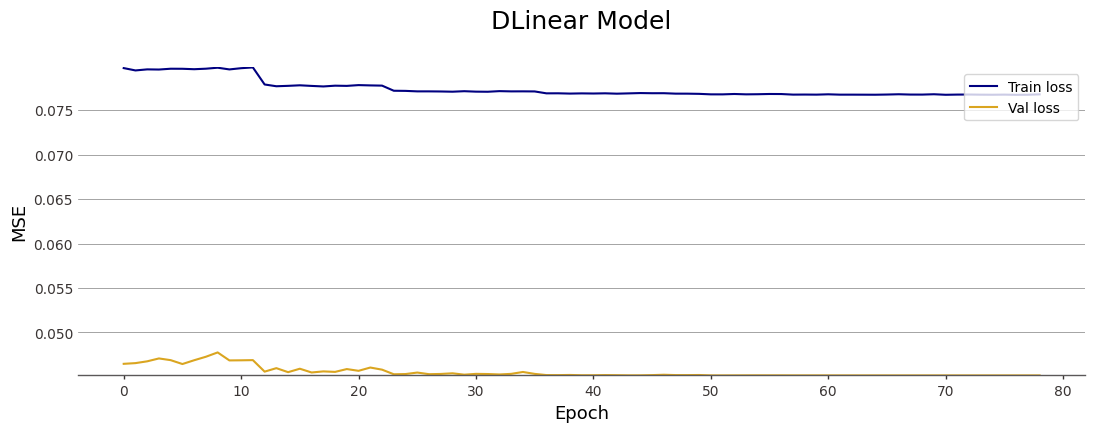

In [ ]:
plt.title("DLinear Model", size=18, y=1.1)
plt.plot(all_losses, label=["Train loss", "Val loss"])
plt.xlabel("Epoch", fontsize=13)
plt.ylabel("MSE", fontsize=13)
plt.legend(loc="upper right", fontsize=10)
plt.show()

## EVALUATION

### Load best checkpoint

In [ ]:
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

### Predict

In [ ]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_pred = model(X.to(device))
            output = torch.cat((output.to(device), y_pred.to(device)), 0)

    return output

In [ ]:
y_pred = predict(test_loader, model).cpu().numpy()

# Inverse the transformation
y_pred_inv = np.expm1(y_pred)
y_test_inv = np.expm1(y_test)

### Metrics


In [ ]:
# Hours ahead to predict
forecast_length = 12

In [ ]:
truth = y_test_inv[:, forecast_length-1, -1]
forecast = y_pred_inv[:, forecast_length-1, -1]

diff = np.subtract(truth, forecast)
# MAPE
mape = np.mean(np.abs(diff / truth))
# RMSE
mse = np.mean(np.square(diff))
rmse = np.sqrt(mse)
# NSE
num = np.sum(np.square(diff))
den = np.sum(np.square(np.subtract(truth, truth.mean())))
nse = 1 - (num / den)

print(f"{forecast_length}-hour forecast MAPE : {mape:.4f}")
print(f"{forecast_length}-hour forecast RMSE: {rmse:.4f}")
print(f"{forecast_length}-hour forecast NSE: {nse:.4f}")

12-hour forecast MAPE : 0.1400
12-hour forecast RMSE: 23.3584
12-hour forecast NSE: 0.6314


### Visualize forecasts

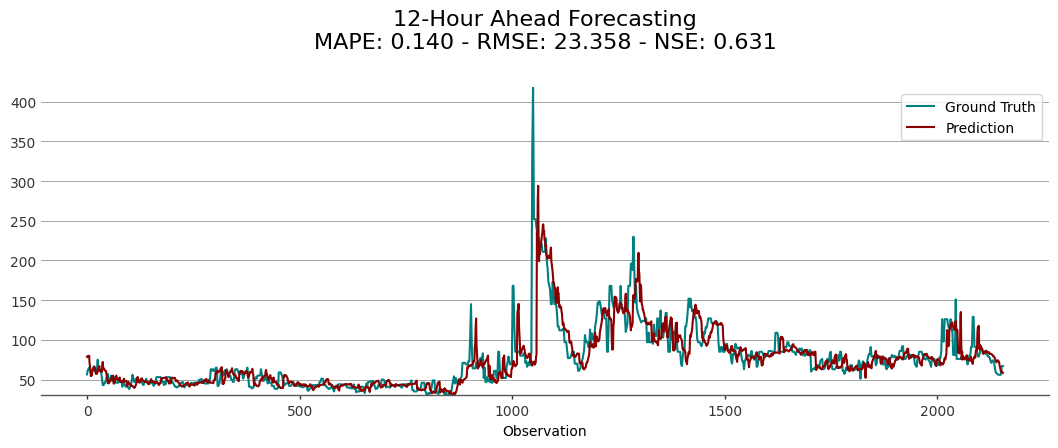

In [ ]:
plt.title(f"{forecast_length}-Hour Ahead Forecasting\nMAPE: {mape:.3f} - RMSE: {rmse:.3f} - NSE: {nse:.3f}", size=16, y=1.1)
plt.plot(truth, label="Ground Truth", color="teal")
plt.plot(forecast, label="Prediction", color="darkred")
plt.xlabel("Observation")
plt.legend(fontsize=10)
plt.show()